# Importation des librairies

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Importer les données

In [88]:
data = pd.read_csv('./data2.csv', sep=";")

## Mise en forme Série Temporelle

In [89]:
#  Séléectionner les bonnes colonnes
data = data.iloc[:, [0, 1, 6]].to_numpy()

# Mettre en Serie temporelle
time_serie = pd.Series(data[:, 2], dtype='float64')

# Retirer les valeurs vides
time_serie = time_serie.dropna()

# Afficher la série temporelle

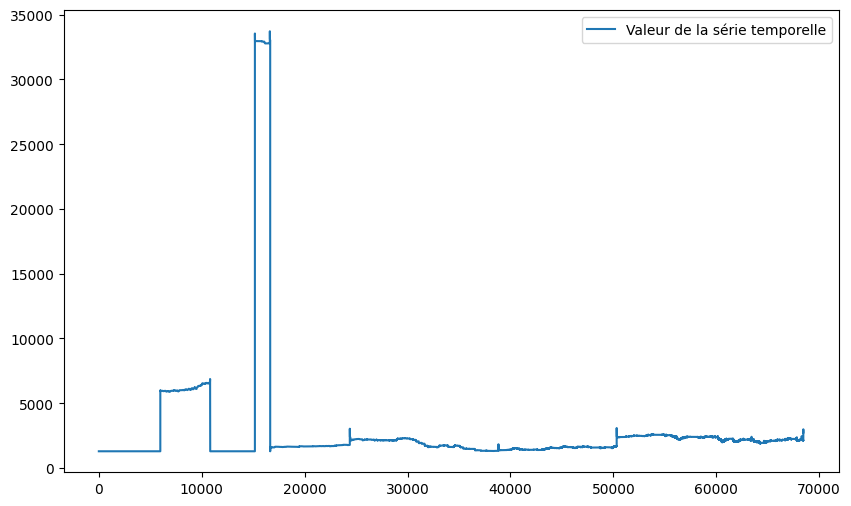

In [90]:
plt.figure(figsize=(10, 6))
plt.plot(time_serie, label='Valeur de la série temporelle')
plt.legend()
plt.show()

On observe que les données sont corrompues
Sur le début de la plage de données, on observe des pallier de valeurs, celles si ne varient pas ou peu et sont subitement projetées sur une autres valeurs. 
Un nettoyage des données se présente comme nécéssaire 

# Nettoyage des données

## On enlève le début

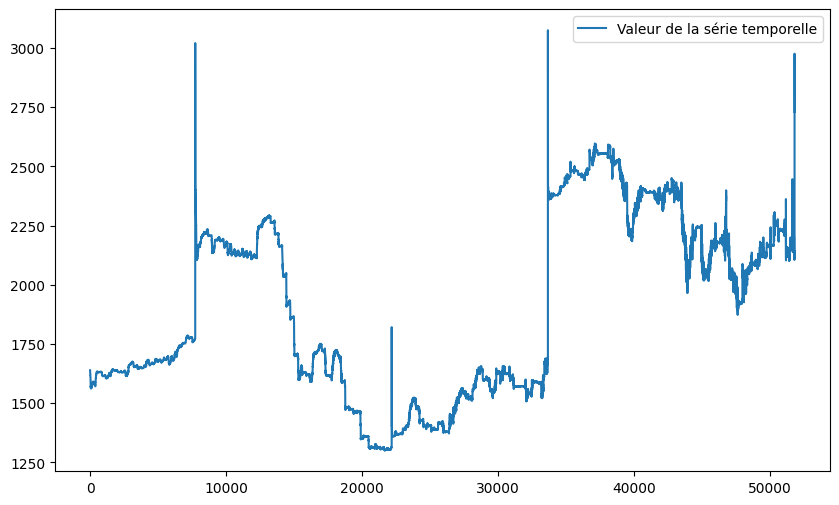

In [109]:
data_crop = data[16656:, 2]

time_serie_crop = pd.Series(data_crop, dtype='float64')
plt.figure(figsize=(10, 6))
plt.plot(time_serie_crop, label='Valeur de la série temporelle')
plt.legend()
plt.show()

## On enlève les pics

### On detecte où sont les pics 

In [164]:
def detect_pic(arr, seuil=100):
    pic_indices = []
    for i in range(1, len(arr) - 1):
        if arr[i] < arr[i + 1] - seuil or arr[i] > arr[i + 1] + seuil:
            pic_indices.append(i-1)
    return pic_indices

indices = detect_pic(data_crop)

print("Indices des pics :", indices)
print("Valeurs des pics :", data_crop[indices])

Indices des pics : [7728, 7729, 7730, 7731, 7734, 22174, 22175, 33661, 33662, 33663, 33664, 33665, 33666, 33667, 45006, 45980, 46697, 46779, 50272, 51167, 51642, 51645, 51798, 51799, 51800, 51804, 51805]
Valeurs des pics : [1772.625 1807.0625 1965.1796875 2146.08984375 2515.96875 1313.0 1313
 1670.09765625 1757.673828125 1914.7119140625 2106.48095703125
 2340.990478515625 2575.5 2460.25 2089 2161 2103 2360.251953125 2166
 2280.75 2258 2314.75 2115.5 2119.25 2227.0 2489.59375 2488]


### On interpole

(51808,) (51808,)


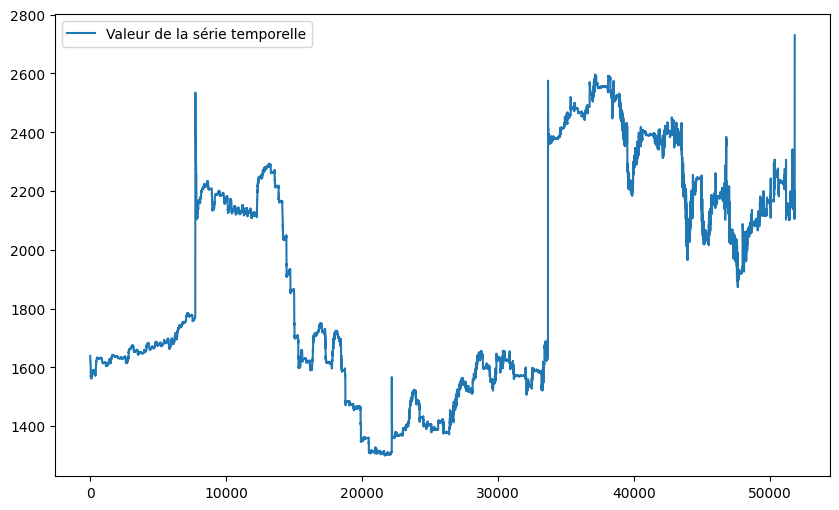

In [165]:
data_clean = delete_pic(data_crop)

print(np.shape(data_crop),np.shape(data_clean))

time_serie_clean = pd.Series(data_clean, dtype='float64')

plt.figure(figsize=(10, 6))
plt.plot(time_serie_clean, label='Valeur de la série temporelle')
plt.legend()
plt.show()

# Première modélisation naïve

In [9]:
# SARIMA parameters
p, d, q = 1, 1, 1    
P, D, Q, s = 1, 1, 1, 96  # Seasonality every 96 time steps

# Building the SARIMA model
model = SARIMAX(time_serie, order=(p, d, q), seasonal_order=(P, D, Q, s))
model_fit = model.fit(disp=False)

# Display the model summary
print(model_fit.summary())

KeyboardInterrupt: 